In [3]:
## PATH settings
import os
import sys
project_root = os.path.abspath(os.path.join(os.getcwd(), '../../'))
sys.path.append(project_root)
COMMON_PATH = os.path.join(project_root, 'common')

In [4]:
## Bespoke class imports
from common.database.adatabase import ADatabase
from common.processor.processor import Processor as p
from financial_common.risk.rolling_factor_analysis import RollingFactorAnalysis
from financial_common.risk.single_index_capm import SingleIndexCAPM
from financial_common.indicator.indicator import Indicator
from financial_common.risk.benchmark import Benchmark
from financial_common.portfolio_management.kpi import KPI
from financial_common.metric.metric import Metric
from financial_common.portfolio_management.portfolio_selection import PortfolioSelection
from financial_common.risk.risk_type import RiskType
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [5]:
## Import standard packages
from datetime import timedelta
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from time import sleep
import copy

In [6]:
market = ADatabase("market")
fred = ADatabase("fred")
orivault = ADatabase("ori")

In [7]:
## Retrieve existing stocks 
market.connect()
index = market.retrieve("index")
market.disconnect()

In [8]:
## Defining Benchmark
market.connect()
benchmark = market.query("prices",{"ticker":"JPM"})
market.disconnect()
benchmark = Benchmark.convert_to_benchmark(benchmark,"adjclose")

In [9]:
rolling_window = 20
market.connect()
prices = []
for ticker in tqdm(index["ticker"]): 
    try:
        price = market.query("prices", {"ticker": ticker})
        if price.index.size > 150:
            price = p.lower_column(price)
            price = p.utc_date(price)
            price.sort_values("date", inplace=True)
            price = p.additional_date_columns(price)
            for member in Metric:
                price = member.calculate(price,timeframe=rolling_window)
            for member in Indicator:
                price = member.calculate(price,timeframe=rolling_window)
            for member in RiskType:
                price = member.apply(price)
            prices.append(price.dropna())
    except Exception as e:
        print(str(e))
        continue
market.disconnect()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11261/11261 [02:33<00:00, 73.33it/s]


In [43]:
portfolios = PortfolioSelection.generate_possible_portfolios(ranking_metrics=["sma","ema","sma_corr","ema_corr"],num_of_groups=[3])
filtered_portfolios = []
for portfolio in portfolios:
        if portfolio.timeframe.value == "week"  and portfolio.selection_type.label == "top" \
                and portfolio.position_type.label == "long" \
                and portfolio.grouping_type.value == "standard_dev" and portfolio.allocation_type.label == "equal":
            portfolio.stoploss = 0.1
            filtered_portfolios.append(portfolio)
len(filtered_portfolios)

4

In [42]:
model_end = 2020
backtest_end = 2026
simulation = pd.concat(prices)
simulation = simulation[(simulation["year"]>=model_end) & (simulation["year"]<backtest_end)]
simulation.sort_values("date", inplace=True)

In [60]:
analysises = []
for min_price in tqdm([1]):
    for max_price in tqdm([3]):
        filtered_simulation = simulation[(simulation["adjclose"]<=max_price) & (simulation["adjclose"]>=min_price)].copy()
        if filtered_simulation.index.size > 0:
            for portfolio in filtered_portfolios:
                try:
                    trades = portfolio.trades(filtered_simulation.copy())
                    performance = portfolio.portfolio(trades.copy(),benchmark.copy())
                    metrics = KPI.performance(trades,performance)
                    results = {**portfolio.to_dict(),**metrics.copy()}
                    results["portfolio"] = portfolio
                    results["rolling_window"] = rolling_window
                    results["max_price"] = max_price
                    results["min_price"] = min_price
                    analysises.append(results)
                except Exception as e:
                    print(str(e))
                    continue

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.72s/it]


In [61]:
a = pd.DataFrame(analysises)

In [62]:
metric = "raw_pnl"
filtered_a = a.drop(["date","risk_type","timeframe","allocation_type","selection_percentage"],axis=1).sort_values(metric,ascending=False)
top = a.sort_values(metric,ascending=False).head(20).to_dict("records")[0]
filtered_a.head(20)

,ranking_metric,position_type,grouping_type,selection_type,stoploss,num_of_groups,pnl,raw_pnl,downside,coefficient_of_variation,portfolio_std,average_gain,average_loss,win_loss_ratio,weekly_return,sharpe_ratio,portfolio,rolling_window,max_price,min_price
2,sma_corr,long,STANDARD_DEV,top,0.1,3,108.114264,166.931210,0.9,2.881303,37.522699,1.084912,0.942561,0.556017,1.021711,2.803067,<financial_common.portfolio_management.portfol...,20,3,1
0,sma,long,STANDARD_DEV,top,0.1,3,86.110233,132.364027,0.9,2.874814,29.953327,1.084237,0.941543,0.554633,1.020686,2.776807,<financial_common.portfolio_management.portfol...,20,3,1
1,ema,long,STANDARD_DEV,top,0.1,3,26.370351,39.886313,0.9,2.299555,11.467590,1.083565,0.941908,0.522822,1.015969,2.043167,<financial_common.portfolio_management.portfol...,20,3,1
3,ema_corr,long,STANDARD_DEV,top,0.1,3,14.280261,28.145207,0.9,3.559190,4.012222,1.074546,0.940566,0.539419,1.012837,2.826393,<financial_common.portfolio_management.portfol...,20,3,1


In [63]:
# orivault.cloud_connect()
# orivault.drop("results")
# orivault.store("results",pd.DataFrame([top]).drop("portfolio",axis=1))
# orivault.disconnect()

In [48]:
a["color"] = ["blue" if x == "top" else "red" if x == "bottom"  else "green" for x in a["selection_type"]]
a["return_to_risk"] = a["pnl"] / a["portfolio_std"]

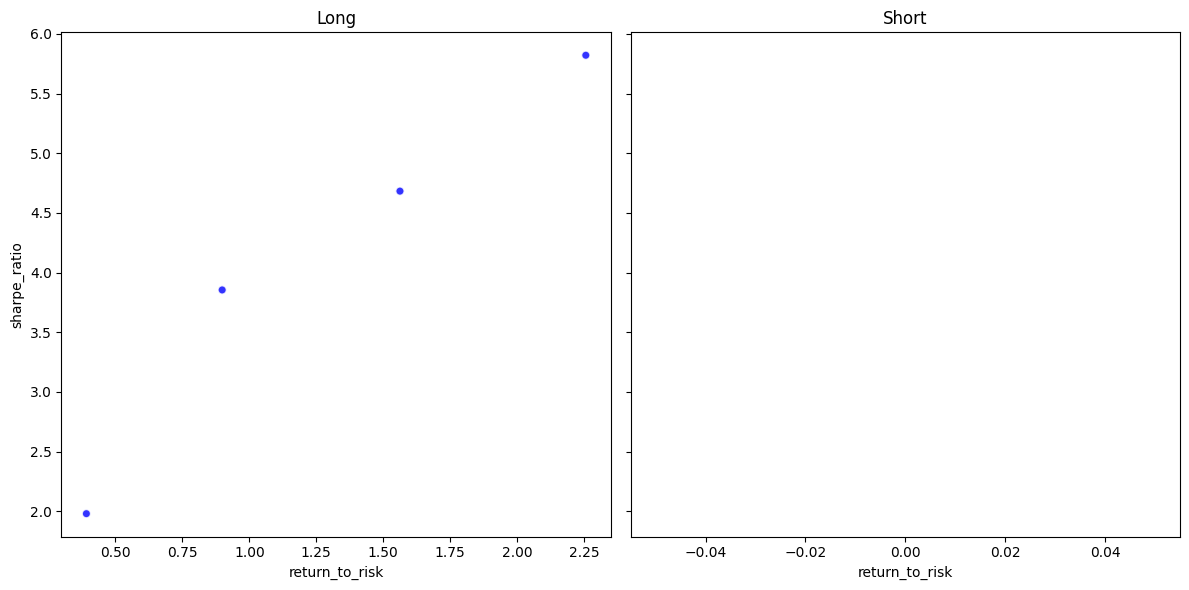

In [49]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Titles for each subplot
titles = ["Long", "Short"]

# Iterate over directions and corresponding axes
for i, position_type in enumerate(["long", "short"]):
    d_analysis = a[a["position_type"] == position_type]
    axes[i].scatter(
        d_analysis["portfolio_std"],
        d_analysis["pnl"],
        c=d_analysis["color"],
        alpha=0.8,
        edgecolors="w",
    )
    axes[i].set_title(titles[i])
    axes[i].set_xlabel("return_to_risk")
    axes[i].set_ylabel("sharpe_ratio" if i == 0 else "")  # Only label y-axis on the first plot

# Adjust layout for better spacing
plt.tight_layout()

# Show the combined plot
plt.show()

In [50]:
pm = top["portfolio"]
filtered_simulation = simulation[(simulation["adjclose"]<=top["max_price"]) & (simulation["adjclose"]>=top["min_price"])]
trades = pm.trades(filtered_simulation.copy())
trades = p.additional_date_columns(trades)
portfolio = pm.portfolio(trades.copy(),benchmark.copy())
portfolio = p.additional_date_columns(portfolio)

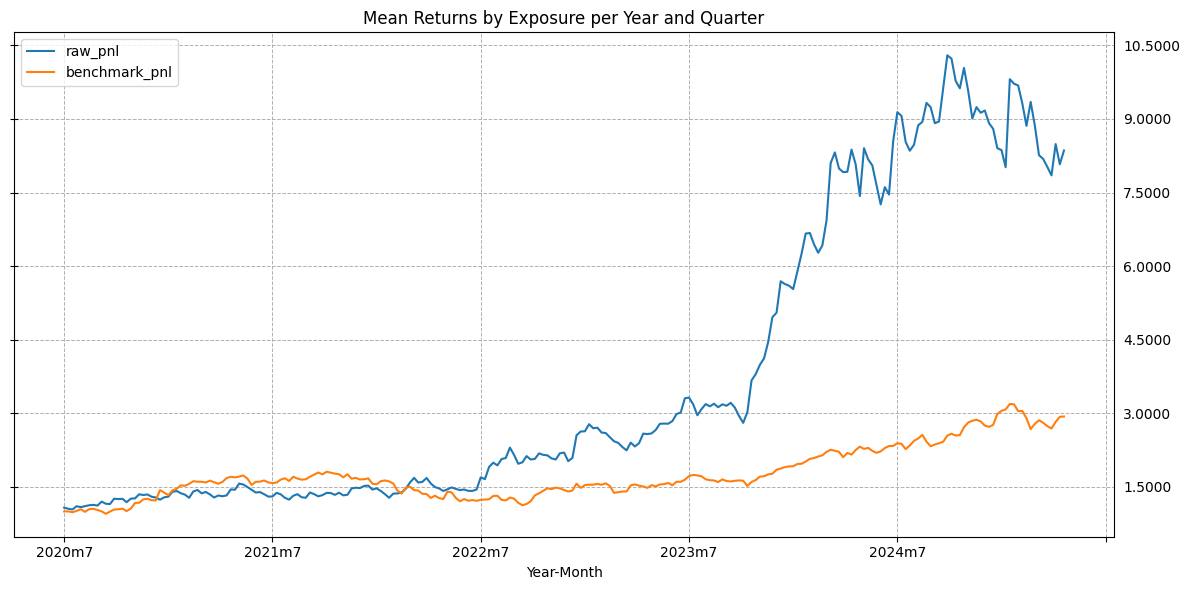

In [51]:
portfolio['Year-Month'] = portfolio["year"].astype(str) + "m" + portfolio["month"].astype(str)
ax = portfolio[["Year-Month","raw_pnl","benchmark_pnl"]].set_index("Year-Month").plot(
    kind="line",
    figsize=(12, 6),
    title="Mean Returns by Exposure per Year and Quarter"
)

# Set y-axis to have more precise ticks
ax.tick_params(axis='y', direction='in', length=6)  # Adjust y-tick direction and length
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.4f}'))  # Format y-ticks with 4 decimal places

# Move y-ticks to the right side
ax.yaxis.set_tick_params(which='both', direction='inout', length=6, labelleft=False, labelright=True)

# Optionally adjust the number of ticks for better precision
ax.yaxis.set_major_locator(plt.MaxNLocator(integer=False, prune='both'))

# Add grid lines
ax.grid(True, which='both', axis='both', linestyle='--', linewidth=0.7)

# Display the plot
plt.tight_layout()
plt.show()

In [52]:
trades[["group_percentile","return"]].groupby("group_percentile").mean().sort_values("return",ascending=False)

,return
group_percentile,
3,1.016520
2,1.008293
1,1.000628


In [53]:
len(filtered_simulation["ticker"].unique())

1085

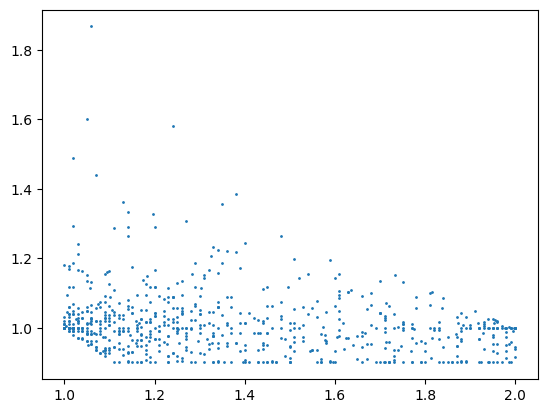

In [54]:
plt.scatter(trades["adjclose"],trades["weighted_return"],s=1)
plt.show()

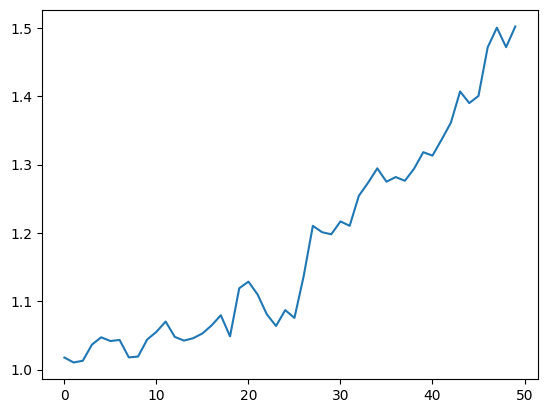

In [56]:
averaged_portfolio = portfolio.groupby("week").agg({"weighted_return":"mean","return":"mean"}).reset_index()
averaged_portfolio["pv"] = averaged_portfolio["return"].cumprod()
plt.plot(averaged_portfolio["pv"])
plt.show()